# Bayesian Regression

The basic idea here is to incorporate priors on regression parameters so as to either incorporate knowledge that we have about our data or to regularize the estimate in some way. Here, I'll do the equivalent of L2 regularization, which penalizes the least-squares solution to a linear regression problem by adding a sum of squares term for the regression coefficients. This amounts to biasing the regression coefficients to zero, i.e. the data must pull the regression coefficients away from zero. In Bayesian terms, the regression coefficients are given a hierarchical prior: a normal distribution with zero mean and variance equal to 1/alpha is placed on each of the coefficients. Alpha is known as the precision of the normal distribution, 1/variance. This value will also be given its own prior distribution, because we cannot know it's best value in advance.

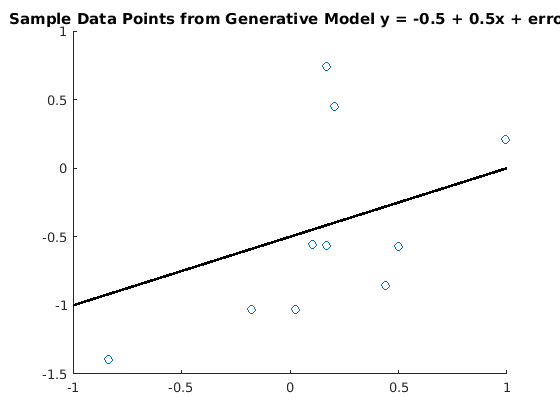

In [9]:
% GENERATE DATA (small amount of data to show the power of the technique)
a = -0.5;b = 0.5;
N = 10;
dataSTD = 0.6;
alpha = 2; % this is the regularization term 
beta = 1/(dataSTD^2); % in L2 regularization, the term is
           % usually called lambda, here lambda = alpha/beta
           
x = unifrnd(-1,1,[N,1]);
y = normrnd(a+b.*x,dataSTD); 

figure();scatter(x,y);
tempx = -1:0.1:1;
hold on;plot(tempx,a+b.*tempx,'k','LineWidth',2);
title('Sample Data Points from Generative Model y = -0.5 + 0.5x + error');

## Analytic Solutions for MLE and MAP

In [10]:
% MLE ... the data standard deviation is unknown
design = [ones(N,1),x];
muMLE = (design'*design)\design'*y;

% Bayes with L2 regularization, assuming data standard deviation is known
muMAP = ((alpha/beta)*eye(2)+(design'*design))\design'*y;

fprintf('True Values: %3.2f %3.2f\n',a,b);
fprintf('MLE: %3.2f %3.2f\n',muMLE(1),muMLE(2));
fprintf('MAP: %3.2f %3.2f\n',muMAP(1),muMAP(2));

True Values: -0.50 0.50
MLE: -0.59 0.83
MAP: -0.52 0.59


The MAP estimate will always have the effect of pulling the regression coefficients toward zero. The extent to which the coefficients are drawn to zero will depend on the amount of data and the value of alpha. Here, we have arbitrarily chosen the value of alpha and also used the true value of beta, which was used to generate the data. These values are rarely known and must therefore either be chosen in advance or estimated from the data.

## MCMC To Do Full Bayesian Inference (assume both alpha and beta unknown)

True Values a -0.50 b 0.50 variance 0.36
Bayesian 95% Posterior Intervals
a [-1.06 -0.11]
b [-0.15 1.75]
Variance [0.23 1.77]
Frequentist 95% Confidence Intervals
a [-1.00 -0.18]
b [-0.04 1.69]


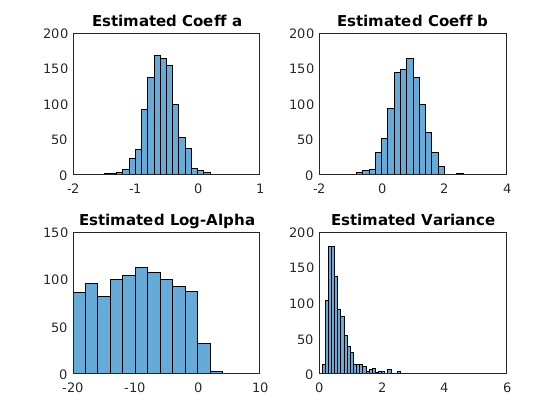

In [11]:
% SET THE PRIORS ON ALPHA AND BETA ... broad priors from the gamma distribution
%   the gamma distribution is commonly used for precision parameters and
%   the inverse gamma distribution is used for variance parameters
abprior = [1e-3,1e3];

% MCMC INITIALIZATION PROCEDURE
numParams = 4;
priorMu = zeros(2,1);priorSigma = eye(2);

burnIn = 1e4;numIter = 6e4;skipRate = 50; % this will generate 1000 samples
params = zeros(numParams,numIter);
posterior = zeros(numIter,1);

% parameter initialization
params(1:2,1) = mvnrnd(priorMu,priorSigma); % initialize regression coefficients
params(3,1) = log(alpha); % initialize alpha with its value from above
params(4,1) = log(1/var(y)); % initialize beta to be 1/var(data)
% the log is taken here because these values tend to vary over a broader range

% calculate unnormalized posterior at this point in the parameter space
convertedData = y-(design*params(1:2,1));
loglikelihood = sum(log(normpdf(convertedData,0,sqrt(1/exp(params(4,1))))));

% sqrt(1/exp(beta-est)) gives the standard deviation ... we are 
%  running the MCMC chain in log space for alpha and beta

prior = log(mvnpdf(params(1:2,1),priorMu,(1/exp(params(3,1))).*priorSigma))+...
    log(gampdf(exp(params(3,1)),abprior(1),abprior(2)))+...
    log(gampdf(exp(params(4,1)),abprior(1),abprior(2)));

posterior(1) = loglikelihood+prior;

% these values set up an adaptive MCMC chain, which 
%   automatically finds an "optimal" proposal distribution
updateParam = 1e-2;
mu = zeros(numParams,1);sigma = eye(numParams);
loglambda = log(2.38^2/numParams);
updateMu = zeros(numParams,1);
updateMu(1:2) = mvnrnd(priorMu,priorSigma)';
updateMu(3) = log(1);
updateMu(4) = log(3);
optimalAccept = 0.44;

for ii=2:numIter
    Z = mvnrnd(mu,exp(loglambda)*sigma)';
    pStar = params(:,ii-1)+Z;
    if sum(pStar(end-1:end)<-20) == 0
        convertedData = y-(pStar(1)+pStar(2).*x);
        loglikelihood = sum(log(normpdf(convertedData,0,sqrt(1/exp(pStar(4))))));
        
        prior = log(mvnpdf(pStar(1:2),priorMu,(1/exp(pStar(3))).*priorSigma))+...
            log(gampdf(exp(pStar(3)),abprior(1),abprior(2)))+...
            log(gampdf(exp(pStar(4)),abprior(1),abprior(2)));
        logA = (loglikelihood+prior)-posterior(ii-1);
        
        if log(rand) < logA
            params(:,ii) = pStar;
            posterior(ii) = loglikelihood+prior;
        else
            params(:,ii) = params(:,ii-1);
            posterior(ii) = posterior(ii-1);
        end

        sigma = sigma+updateParam.*((params(:,ii)-updateMu)*...
            (params(:,ii)-updateMu)'-sigma);
        updateMu = updateMu+updateParam.*(params(:,ii)-updateMu);
        loglambda = loglambda+updateParam.*(exp(min(0,logA))-optimalAccept);
    else
        params(:,ii) = params(:,ii-1);
        posterior(ii) = posterior(ii-1);
        loglambda = loglambda+updateParam.*(-optimalAccept);
    end
end
params(3,:) = params(3,:);
params(4,:) = 1./exp(params(4,:)); % convert back to the original parameter space

% skip samples because they are almost always auto-correlated (not independent samples from the
%  posterior) ... I have checked this beforehand for this dataset, but it's a step that
%  should be done every time you use MCMC
posteriorSamples = params(:,burnIn:skipRate:end);

figure();titles = {'Estimated Coeff a','Estimated Coeff b','Estimated Log-Alpha','Estimated Variance'};
for ii=1:4
    subplot(2,2,ii);histogram(posteriorSamples(ii,:));
    title(titles{ii});
end

mcmcMu = mean(posteriorSamples,2);
aConfInterval = quantile(posteriorSamples(1,:),[0.05/2,1-0.05/2]);
bConfInterval = quantile(posteriorSamples(2,:),[0.05/2,1-0.05/2]);
varConfInterval = quantile(posteriorSamples(4,:),[0.05/2,1-0.05/2]);

dataVar = dataSTD^2;
fprintf('True Values a %3.2f b %3.2f variance %3.2f\n',a,b,dataVar);

fprintf('Bayesian 95%% Posterior Intervals\n');
fprintf('a [%3.2f %3.2f]\n',aConfInterval(1),aConfInterval(2));
fprintf('b [%3.2f %3.2f]\n',bConfInterval(1),bConfInterval(2));
fprintf('Variance [%3.2f %3.2f]\n',varConfInterval(1),varConfInterval(2));

% re-calculate the MLE with MATLAB's glmfit to get a 95% confidence interval
[b,~,stats] = glmfit(design,y,'normal','constant','off');

a95 = [b(1)-2*stats.se(1),b(1)+2*stats.se(1)];
b95 = [b(2)-2*stats.se(2),b(2)+2*stats.se(2)];

fprintf('Frequentist 95%% Confidence Intervals\n');
fprintf('a [%3.2f %3.2f]\n',a95(1),a95(2));
fprintf('b [%3.2f %3.2f]\n',b95(1),b95(2));

The main things to note here are the differences between Bayesian and frequentist inference. Both versions yielded 95% intervals which trapped the true values of the regression coefficients (a and b). Bayesian inference, however, provides posterior distributions on the model parameters, which means that when we go to make predictions, we don't actually predict single values. For example, if we use the MLE estimates for a and b (-0.62 and 0.33), then for any given future data point, x-i, we would predict that y-i = -0.62+0.33x-i . We could use our confidence interval to set error bars on this prediction, but maximum likelihood systematically underestimates the variance parameter, so we'll tend to be too certain in our predictions, even if we include the error bars. The Bayesian estimate provides posterior distributions for each of the unknown parameters, including the variance, and we can make predictions using the posterior predictive distribution, which will be the marginal distribution of [a,b,variance], with alpha marginalized out. Our prediction is itself a probability distribution. If we want to see that distribution, we draw randomly (uniform) from the posterior and then use the values for [a,b,variance] to draw a new value for the prediction [from a normal distribution, as in the generative model above] (I'll do that below). Bayesian inference also skews the values for a and b toward zero, as mentioned above. We can see by the slight skew in the left-hand side of the distribution for a and the right-hand side of the distribution for b.

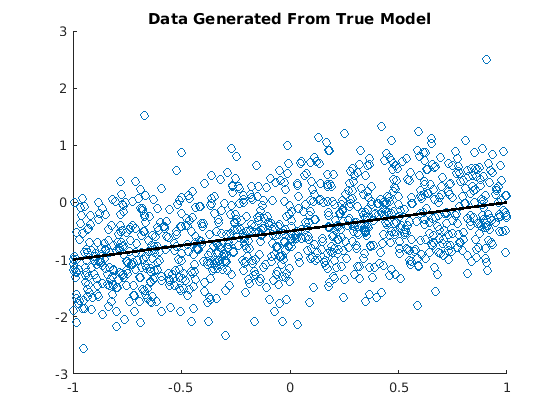

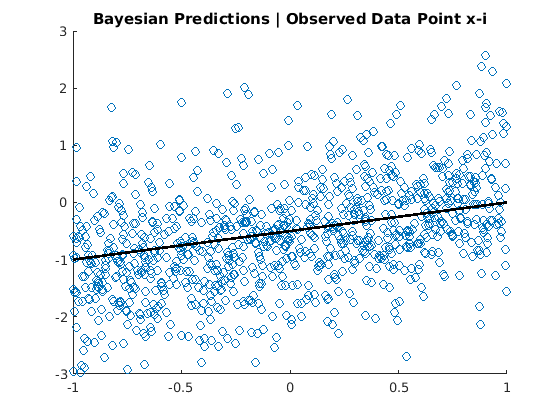

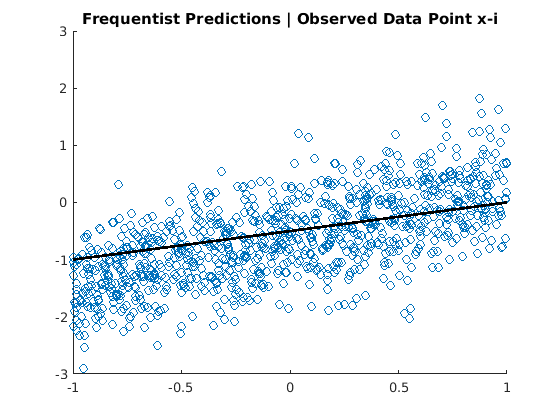

In [13]:
% FREQUENTIST PREDICTIONS
predN = 1000;
x = unifrnd(-1,1,[predN,1]);
y = zeros(predN,1);

for ii=1:predN
    tempa = b(1);tempb = b(2);stdev = std(stats.residd);
    y(ii) = normrnd(tempa+x(ii)*tempb,stdev);
end

figure();scatter(x,y);axis([-1 1 -3 3]);
tempx = -1:0.1:1;
hold on;plot(tempx,-0.5+tempx.*0.5,'k','LineWidth',2);
title('Frequentist Predictions | Observed Data Point x-i');

% BAYESIAN POSTERIOR PREDICTIONS
y = zeros(predN,1);
totalSamples = length(posteriorSamples);
for ii=1:predN
    index = random('Discrete Uniform',totalSamples);
    sample = posteriorSamples([1,2,4],index);
    y(ii) = normrnd(sample(1)+x(ii)*sample(2),sqrt(sample(3)));
end

figure();scatter(x,y);axis([-1 1 -3 3]);
tempx = -1:0.1:1;
hold on;plot(tempx,-0.5+tempx.*0.5,'k','LineWidth',2);
title('Bayesian Predictions | Observed Data Point x-i');

% SAMPLES DRAW FROM TRUE DISTRIBUTION
y = zeros(predN,1);

for ii=1:predN
    y(ii) = normrnd(-0.5+x(ii)*0.5,dataSTD);
end

figure();scatter(x,y);axis([-1 1 -3 3]);
tempx = -1:0.1:1;
hold on;plot(tempx,-0.5+tempx.*0.5,'k','LineWidth',2);
title('Data Generated From True Model');

[black lines represent the generative model] As we can see, the frequentist estimate is just a bit too confident (the values are more condensed around the true line than for the generative model). It's over-estimated it's confidence because it under-estimated the variance. The Bayesian model has over-estimated the variance of the generative model, but it has reliably and accurately propagated our uncertainty given the data provided. A range of models (defined by a,b, and the variance) could have generated the data and the Bayesian method gives us a more realistic best guess given that uncertainty.